# JOLLY Preprocessing Scripts
by MG Malana and Jerelyn Co

### General tasks:
- [x] collate labeled files in one dataframe
- [x] collate and preprocess (if necessary) test scores
- [x] provide basic quali and quanti analyses

### Subtasks:
- [x] histogram of final vote classes (overall and per university)
- [x] normalized histogram of final vote classes (per university) 
- [x] box plot of test scores per university
- [x] interrator score

### To check
- dapat walang "VOTE" under final act
- delete other columns

### Notes:
Possible errors on the assigned student id in the following files:
- ADDU-DP05A - DP05B.xlsx
- ADDU-DP06A - DP06B.xlsx

Missing scores for the following students:
- ADNU-DP06A
- ADNU-DP06B
- ADNU-DP05A
- ADNU-DP05B
- ADMU-DP04A
- ADMU-DP04B

In [1]:
# Importing packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import glob
%pylab inline
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_dir = 'data/'
data_raw_dir = data_dir +'raw/'
data_proc_dir = data_dir +'proc/'

data_raw_label_dir = data_raw_dir + 'label/'
data_raw_score_dir = data_raw_dir + 'scores/'

# Labelled Dataset

Contains the chat logs between the pair programmer, translation to English language, votes of each voter, final vote for cases of conflict, and timestamp.

## Collation and preliminary preprocessing

In [3]:
# merge all excels into 1 data frame
label_df = pd.DataFrame()
column_names = ['text', 'person', 'translation', 'a1', 'a2', 'match', 'final_act', 'timestamp', 'school', 'filename', 'student']
column_name_change = {'TEXT': 'text', 'ORIGINAL TEXT/CONVO': 'text', 'Original text': 'text', 'PERSON': 'person',
                      'TRANSLATION': 'translation', 'A1': 'a1',
                      'A2': 'a2', 'Match': 'match', 'MATCH': 'match',
                      'FINAL': 'final_act', 'Final Act': 'final_act', 'Timestamp': 'timestamp', 'Student': 'student'}

In [4]:
# iterate folders
for folder in glob.iglob(data_raw_label_dir + '*/'):
    for filename in glob.iglob(folder +'*.xlsx'):
        filename = filename.replace(folder, '')
        if filename in ["ADDU-DP05A - DP05B.xlsx", "ADDU-DP06A - DP06B.xlsx"]:
            continue

        school_name = folder.replace(data_raw_label_dir, '').replace('/', '')
        
        
        temp_df = pd.read_excel(data_raw_label_dir + school_name + '/' + filename)
        temp_df = temp_df.rename(columns= column_name_change)

        # add additional columns
        temp_df['school'] = school_name
        temp_df['filename'] = filename
        
        # setting timestamp and student
        if not temp_df.index.is_integer():
            index_split = list(temp_df.index.str.split(':', 1))           
            temp_df['timestamp'] = np.array(index_split)[:,1]
            temp_df['student'] = np.array(index_split)[:,0]
            # convert to military time
            temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp']).dt.strftime('%H:%M:%S')
        else: 
            temp_df.index = temp_df['student'] + ":" + temp_df['timestamp'].astype(str)

        # filling na values in timestamp and student. get last valid observation
        temp_df['student'] = temp_df['student'].fillna(method="ffill")
        temp_df['timestamp'] = temp_df['timestamp'].fillna(method="ffill")

        # remove extra columns
        temp_df = temp_df.drop(set(temp_df.columns) - set(column_names), axis=1)
#          temp_df = temp_df.loc[:, ~temp_df.columns.str.contains('^Unnamed')] # remove unnamed columns     
        
        # error checking on data
        if not set(column_names).issubset(temp_df.columns):                # check if incomplete columns
            raise Exception('Column names in ' + filename + ' are incomplete')
        if not set(temp_df.columns).issubset(column_names):                # check if has extra columns
            raise Exception('There are extra column names in ' + filename)
        if temp_df['final_act'].isnull().any():                            # check if final act has null
            raise Exception('Null final act in ' + filename)
        if temp_df['final_act'].str.match('VOTE').any():                   # check if final act has 'VOTE' value
            raise Exception('Invalid final act in ' + filename)
        
        label_df = label_df.append(temp_df)

label_df.head()

/home/jerelyn/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,a1,a2,filename,final_act,match,person,school,student,text,timestamp,translation
ADMU-SPx1A:10:45:48,InfStm,InfStm,ADMU-SPx1A-SPx1B.xlsx,InfStm,True,A,ADMU,ADMU-SPx1A,test,10:45:48,test
ADMU-SPx1A:11:46:09,InfNon,InfNon,ADMU-SPx1A-SPx1B.xlsx,InfNon,True,A,ADMU,ADMU-SPx1A,.,11:46:09,.
ADMU-SPx1B:11:46:51,InfNon,InfNon,ADMU-SPx1A-SPx1B.xlsx,InfNon,True,B,ADMU,ADMU-SPx1B,(H),11:46:51,(H)
ADMU-SPx1A:11:47:01,InfNon,InfNon,ADMU-SPx1A-SPx1B.xlsx,InfNon,True,A,ADMU,ADMU-SPx1A,8-|,11:47:01,8-|
ADMU-SPx1A:11:49:13,InfSol,InfSol,ADMU-SPx1A-SPx1B.xlsx,InfSol,True,A,ADMU,ADMU-SPx1A,reverse is spelled wrong,11:49:13,reverse is spelled wrong


In [5]:
label_df.index.name='index'
label_df.to_csv(data_proc_dir + 'labelled_data.csv')

## Preliminary EDA

In [6]:
# Loading dataset
label_df = pd.read_csv(data_proc_dir + 'labelled_data.csv', index_col='index')

# Selecting three schools for now: ADMU, ADDU, ADNU
label_df = label_df[label_df["school"].isin(["ADMU", "ADNU", "ADDU", "UC"])]

==== Per School count ====
ADMU    2752
ADNU    2111
ADDU    1639
UC      1213
Name: school, dtype: int64
==== Total number of lines ====
7715


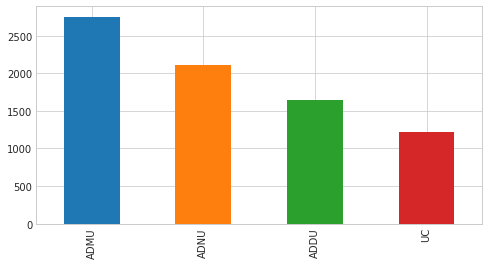

In [7]:
# Showing value counts (number of lines) per school
plt.figure(figsize=(8,4))
label_df["school"].value_counts().plot(kind="bar")

# Showing the numbers

print("==== Per School count ====")
print(label_df["school"].value_counts())
print("==== Total number of lines ====")
total_size = len(label_df)
print(total_size)

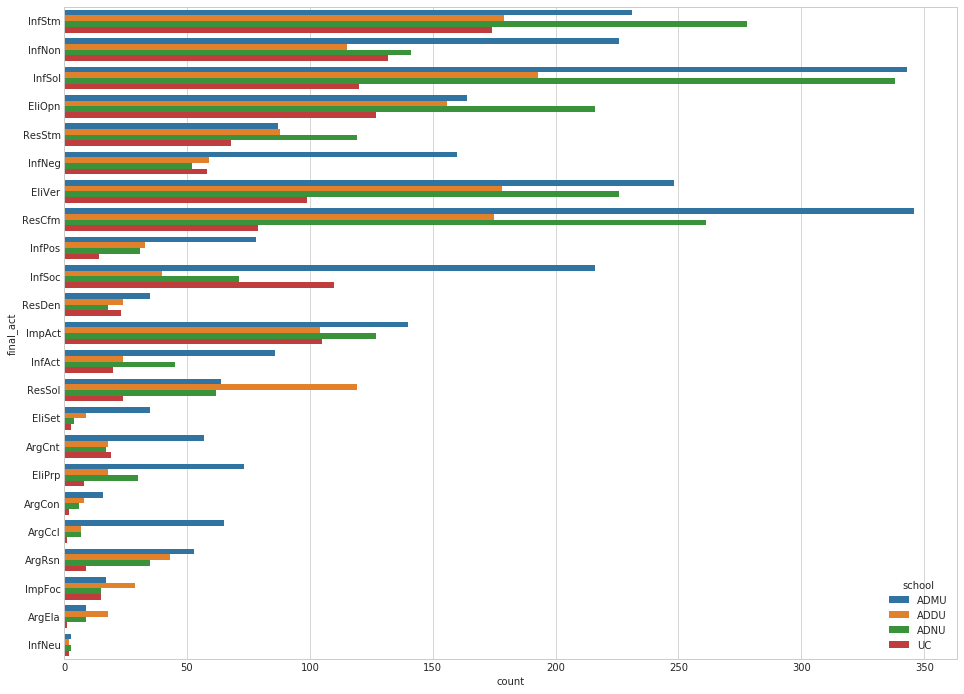

In [8]:
# Showing breakdown of votes per class
plt.figure(figsize=(16,12))
sns.countplot(y="final_act", hue="school", data=label_df)

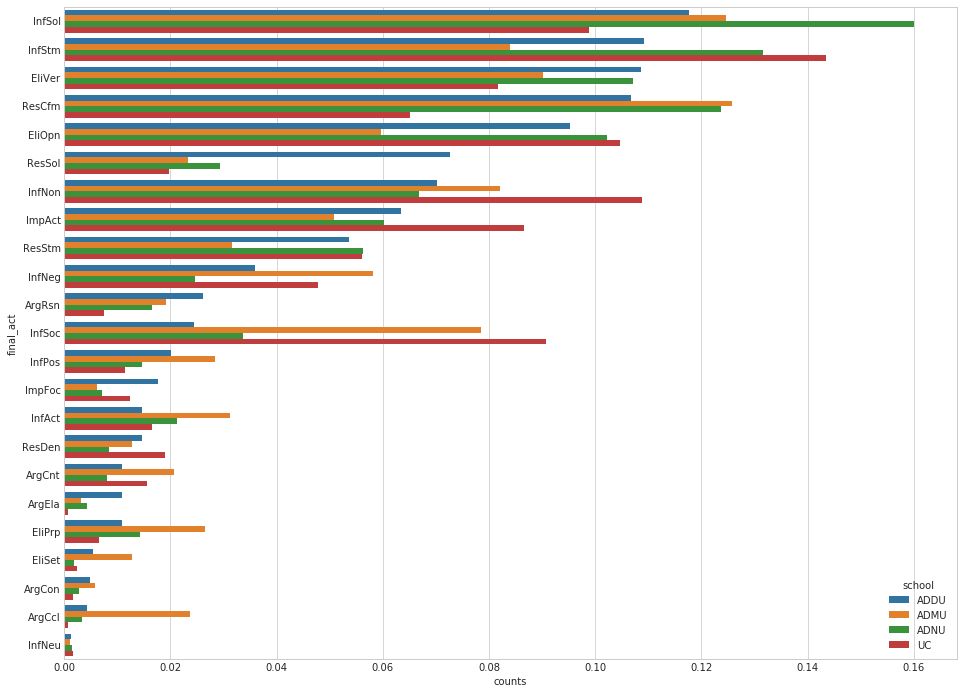

In [9]:
# Showing normalized breakdown of votes per class
label_norm_df = label_df.groupby(['school'])['final_act'].value_counts(normalize=True).reset_index(name='counts')

plt.figure(figsize=(16,12))
sns.barplot(x="counts", y="final_act", hue="school", data=label_norm_df)

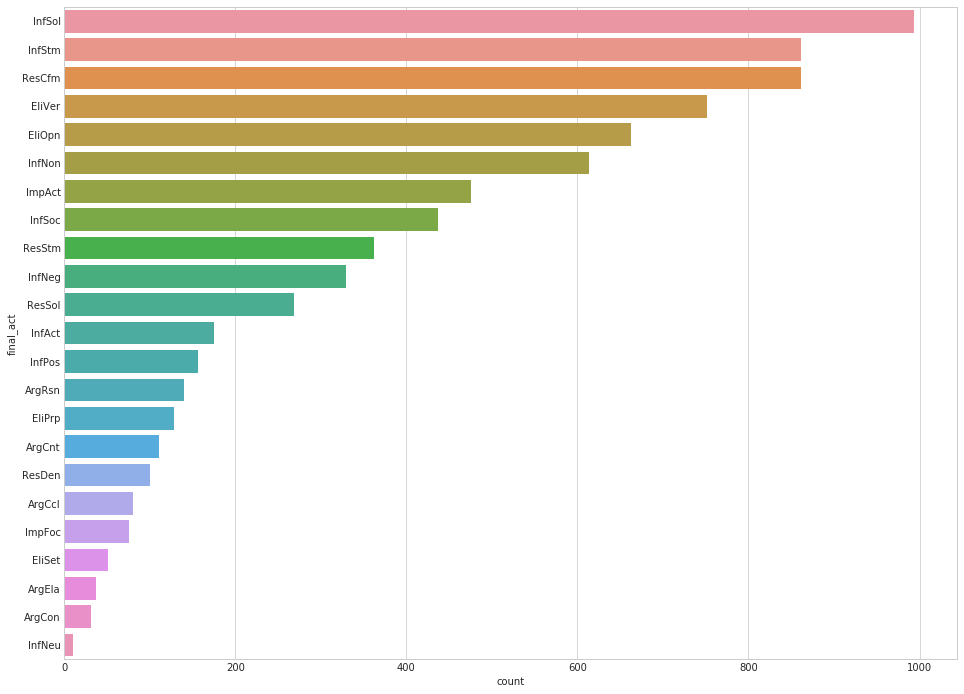

In [10]:
plt.figure(figsize=(16,12))
sns.countplot(y="final_act", data=label_df, order = label_df['final_act'].value_counts().index)

In [11]:
# Rater Scores
print("==== Rater scores ====")
a1_rating = print("A1: {}%".format(len(label_df[label_df['a1'] == label_df['final_act']]) * 100/total_size))
a2_rating = print("A2: {}%".format(len(label_df[label_df['a2'] == label_df['final_act']]) * 100/total_size))

==== Rater scores ====
A1: 95.59300064808814%
A2: 90.83603370058329%


# Scores Dataset

In [13]:
# read and clean dataset
scores_df = pd.read_excel(data_raw_score_dir + 'all scores.xlsx')
scores_df = scores_df.dropna()
scores_df = scores_df.rename(columns= {'Student ID': 'student', 'School': 'school', 'Static / Dynamic': 'static_or_dynamic',
                                      'Individual / Pair': 'individual_or_pair', 'Gender': 'gender',
                                      'Pre-test score': 'pre_test_score', 'Self-efficacy': 'self_efficacy',
                                      'Debugging scores': 'debugging_scores'})
scores_df["static_or_dynamic"] = scores_df["static_or_dynamic"].apply(lambda x: x.strip())
scores_df = scores_df[~scores_df["student"].isin(["ADNU-DP06A", "ADNU-DP06B", "ADNU-DP05A", "ADNU-DP05B","ADMU-DP04A", 
                                                  "ADMU-DP04B", "ADDU-DP05A", "ADDU-DP05B", "ADDU-DP06A", "ADDU-DP06B"])]
scores_df.head()


,student,school,static_or_dynamic,individual_or_pair,gender,pre_test_score,self_efficacy,debugging_scores
0,ADDU-DP02A,ADDU,Dynamic,Pair,F,6.0,4.88,13.0
1,ADDU-DP02B,ADDU,Dynamic,Pair,F,4.0,4.32,13.0
2,ADDU-DP03B,ADDU,Dynamic,Pair,F,4.0,3.53,10.0
3,ADDU-DP07B,ADDU,Dynamic,Pair,F,7.0,3.74,18.0
4,ADDU-SP02A,ADDU,Static,Pair,F,7.0,5.69,14.5


In [14]:
scores_df.to_csv(data_proc_dir + 'scores.csv')

## Preliminary EDA

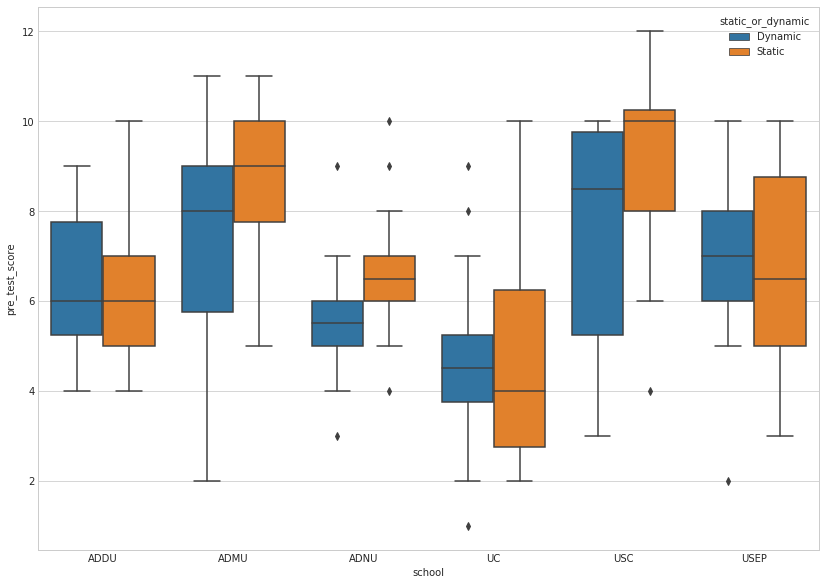

In [15]:
plt.figure(figsize=(14,10))
sns.boxplot(x="school", hue="static_or_dynamic", y="pre_test_score", data=scores_df)

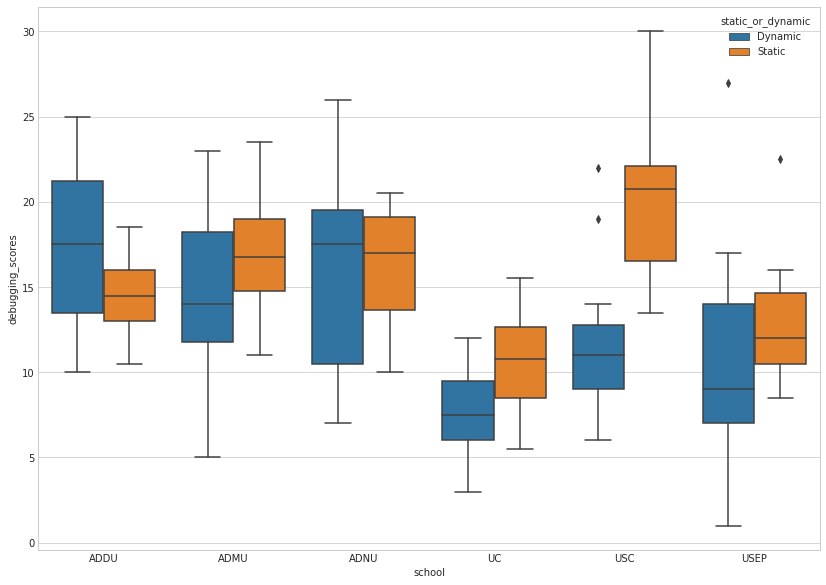

In [16]:
plt.figure(figsize=(14,10))
sns.boxplot(x="school", hue="static_or_dynamic", y="debugging_scores", data=scores_df)

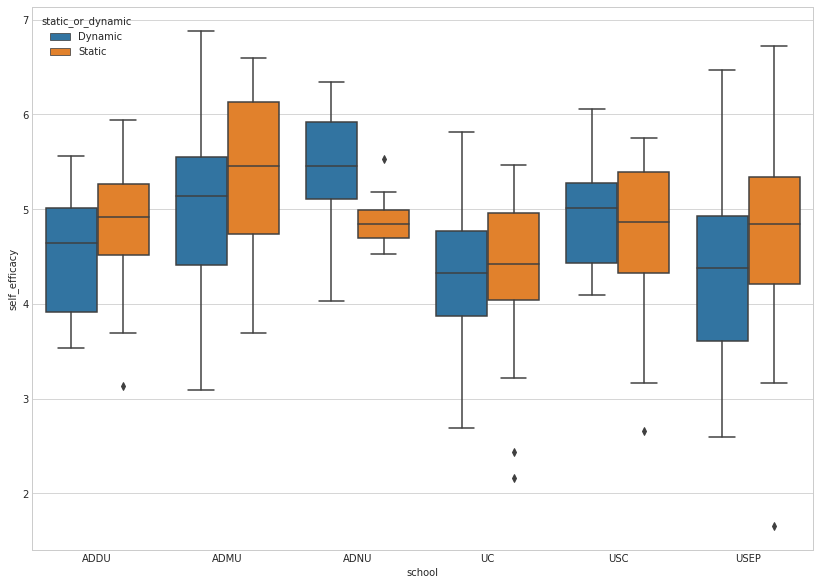

In [17]:
plt.figure(figsize=(14,10))
sns.boxplot(x="school", hue="static_or_dynamic", y="self_efficacy", data=scores_df)

## Merged label counts (per student) and score dataset

In [18]:
#get counts of final act per student
stud_df = label_df.groupby(['student'])['final_act'].value_counts().reset_index(name='counts')

# reshape the dataframe
stud_df = stud_df.pivot(index='student', columns='final_act')['counts']

# fill N/A
stud_df = stud_df.fillna(0)
stud_df.head()

final_act,ArgCcl,ArgCnt,ArgCon,ArgEla,ArgRsn,EliOpn,EliPrp,EliSet,EliVer,ImpAct,...,InfNeu,InfNon,InfPos,InfSoc,InfSol,InfStm,ResCfm,ResDen,ResSol,ResStm
student,,,,,,,,,,,,,,,,,,,,,
ADDU-DP01A,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,3.0,4.0,...,0.0,5.0,0.0,2.0,1.0,2.0,3.0,0.0,1.0,1.0
ADDU-DP01B,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,1.0,1.0,2.0,3.0,5.0,4.0,0.0,3.0,2.0
ADDU-DP02A,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,13.0,6.0,...,0.0,4.0,3.0,0.0,9.0,11.0,3.0,1.0,3.0,3.0
ADDU-DP03A,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0
ADDU-DP03B,0.0,0.0,0.0,1.0,0.0,4.0,3.0,0.0,6.0,7.0,...,0.0,2.0,2.0,0.0,4.0,12.0,6.0,1.0,11.0,4.0


In [19]:
stud_df = stud_df.join(scores_df.set_index('student'))
stud_df.head()

,ArgCcl,ArgCnt,ArgCon,ArgEla,ArgRsn,EliOpn,EliPrp,EliSet,EliVer,ImpAct,...,ResDen,ResSol,ResStm,school,static_or_dynamic,individual_or_pair,gender,pre_test_score,self_efficacy,debugging_scores
student,,,,,,,,,,,,,,,,,,,,,
ADDU-DP01A,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,3.0,4.0,...,0.0,1.0,1.0,ADDU,Dynamic,Pair,M,8.0,5.53,25.0
ADDU-DP01B,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,3.0,2.0,ADDU,Dynamic,Pair,M,9.0,5.56,22.0
ADDU-DP02A,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,13.0,6.0,...,1.0,3.0,3.0,ADDU,Dynamic,Pair,F,6.0,4.88,13.0
ADDU-DP03A,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,ADDU,Dynamic,Pair,M,8.0,5.06,17.0
ADDU-DP03B,0.0,0.0,0.0,1.0,0.0,4.0,3.0,0.0,6.0,7.0,...,1.0,11.0,4.0,ADDU,Dynamic,Pair,F,4.0,3.53,10.0


In [20]:
stud_df.to_csv(data_proc_dir + 'student_data.csv')